## Project Scope
- Analyse the given data about endangered animal;
- Create visual plots to connect the information within the data sets;
- Answer some questions on the data to look for insights, such as:
    - What is the distribution of conservation_status for animals?
    - Are certain types of species more likely to be endangered?
    - Are the differences between species and their conservation status significant?
    - Which species were spotted the most at each park?
- Create a slide presentation with project analysis and conclusions.

### Import Libs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting settings
sns.set_style("darkgrid")
sns.set_context("paper")

### Function Definitions

In [2]:
def plot_bar_percentages(g, include_values=False, label_type='edge', padding=3, **kwargs):
    if len(g.containers) > 1:
        total = sum([container.datavalues for container in g.containers])
        for i in range(len(g.containers)):
            labels = [f'{j * 100 :.1f}%' for j in g.containers[i].datavalues / total]
            if include_values:
                values = g.containers[i].datavalues
                labels = [f'{int(value)} ({label})' for value, label in zip(values, labels)]
            g.bar_label(g.containers[i], labels=labels, label_type=label_type, padding=padding, **kwargs)
    else:
        labels = [f'{i * 100 :.1f}%' for i in g.containers[0].datavalues / sum(g.containers[0].datavalues)]
        if include_values:
            values = g.containers[0].datavalues
            labels = [f'{int(value)} ({label})' for value, label in zip(values, labels)]
        g.bar_label(g.containers[0], labels=labels, label_type=label_type, padding=padding, **kwargs)

### Load Data

In [3]:
info = pd.read_csv('../Data/Raw/species_info.csv')
obs = pd.read_csv('../Data/Raw/observations.csv')

print('*' * 50, 'SPECIES INFO DATA SET', '*' * 50)
display(info.head())
print(info.shape)
print('*' * 50, 'OBSERVATIONS DATA SET', '*' * 50)
display(obs.head())
print(obs.shape)

************************************************** SPECIES INFO DATA SET **************************************************


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


(5824, 4)
************************************************** OBSERVATIONS DATA SET **************************************************


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


(23296, 3)


In [4]:
# Rename missing values in conservation_status column
info.conservation_status.fillna('Unclassified', inplace=True)

# Create DF with only classified species
classified = info[info.conservation_status != 'Unclassified']
classified

,category,scientific_name,common_names,conservation_status
7,Mammal,Canis latrans,Coyote,Species of Concern
8,Mammal,Canis lupus,Gray Wolf,Endangered
9,Mammal,Canis rufus,Red Wolf,Endangered
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern
...,...,...,...,...
5302,Vascular Plant,Callitriche marginata,Winged Water-Starwort,Species of Concern
5399,Vascular Plant,Camissonia sierrae ssp. alticola,"Mono Hot Springs Evening Primrose, Mono Hot Sp...",Species of Concern
5426,Vascular Plant,Epilobium oreganum,"Grants Pass Willowherb, Oregon Fireweed",Species of Concern
5436,Vascular Plant,Botrychium ascendens,"Trianglelobe Moonwort, Upswept Moonwort",Species of Concern


### First Analysis

In [5]:
print('Species Categories:', info.category.unique().tolist())
print('Different Species:', info.scientific_name.nunique())
print('Species Conservation Status:', info.conservation_status.unique().tolist())
print('Park Names:', obs.park_name.unique().tolist())

Species Categories: ['Mammal', 'Bird', 'Reptile', 'Amphibian', 'Fish', 'Vascular Plant', 'Nonvascular Plant']
Different Species: 5541
Species Conservation Status: ['Unclassified', 'Species of Concern', 'Endangered', 'Threatened', 'In Recovery']
Park Names: ['Great Smoky Mountains National Park', 'Yosemite National Park', 'Bryce National Park', 'Yellowstone National Park']


### Data Visualization

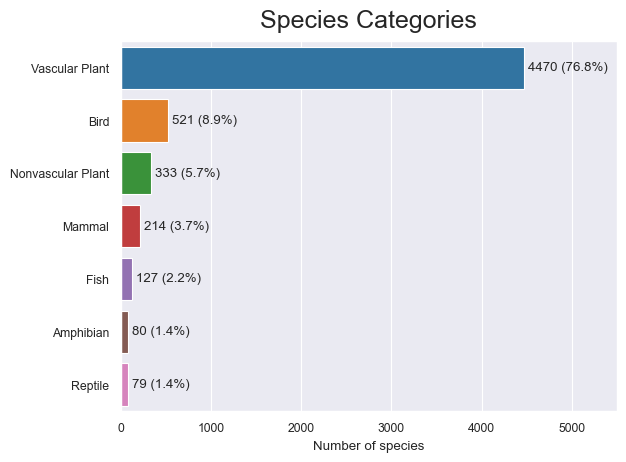

In [6]:
g = sns.countplot(data=info, y='category', order=info.category.value_counts().index)
plt.title('Species Categories', fontsize=18, pad=10)
plt.xlim(0, 5500)
plot_bar_percentages(g, include_values=True)
g.set(ylabel='', xlabel='Number of species');

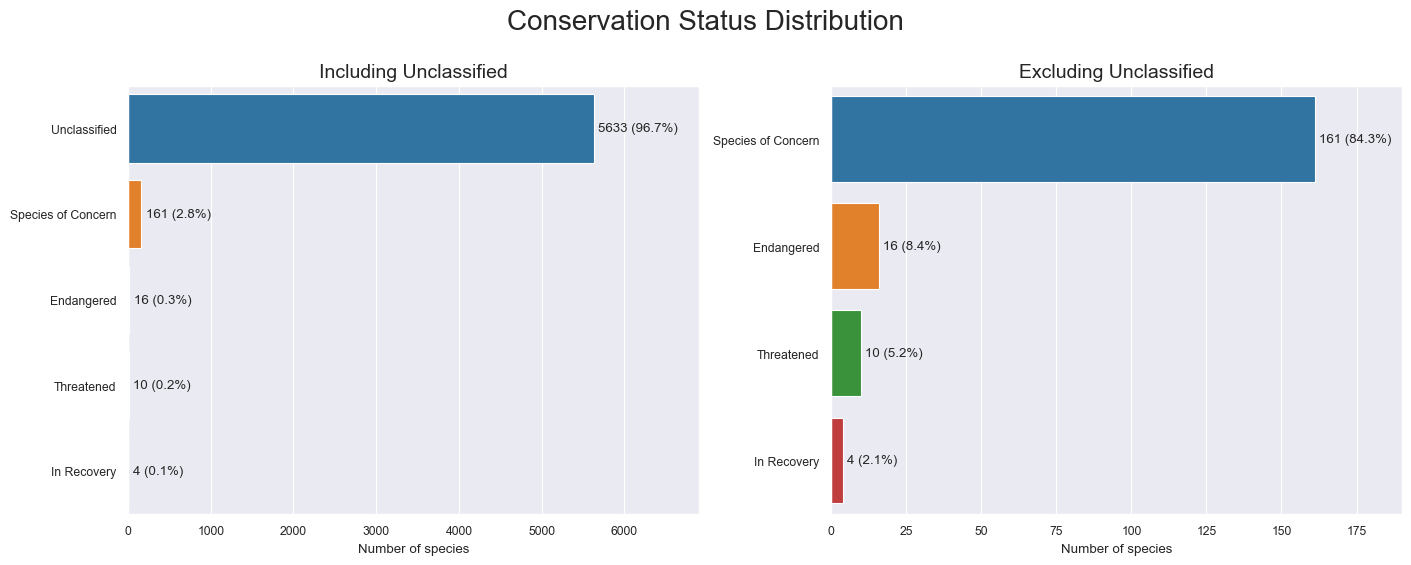

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), layout='constrained')
fig.suptitle('Conservation Status Distribution', fontsize=20, y=1.1)

g1 = sns.countplot(data=info, y='conservation_status', order=info.conservation_status.value_counts().index, ax=axs[0])
g1.set_title('Including Unclassified', fontsize=14)
g1.set_xlim(0, 6900)
plot_bar_percentages(g1, include_values=True)
g1.set(ylabel='', xlabel='Number of species')

g2 = sns.countplot(data=classified, y='conservation_status', order=classified.conservation_status.value_counts().index, ax=axs[1])
g2.set_title('Excluding Unclassified', fontsize=14)
g2.set_xlim(0, 190)
plot_bar_percentages(g2, include_values=True)
g2.set(ylabel='', xlabel='Number of species');

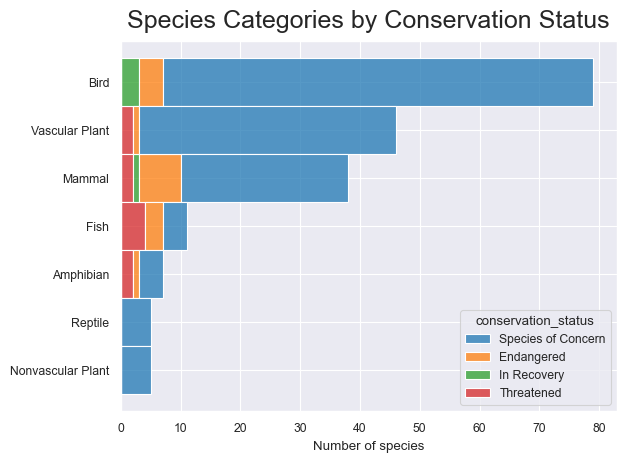

In [82]:
# Sort DF by category counts
category_counts = classified['category'].value_counts()
sorted_classified = classified.sort_values(by='category', key=lambda x: x.map(category_counts), ascending=False)

# Plot species categories by conservation status, excluding unclassified species
sns.histplot(data=sorted_classified, y='category', hue='conservation_status', multiple='stack')
plt.title('Species Categories by Conservation Status', fontsize=18, pad=10)
plt.ylabel('')
plt.xlabel('Number of species');

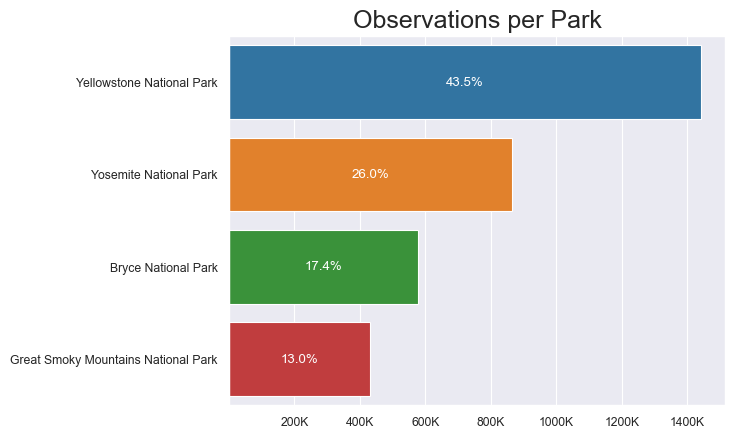

In [8]:
observations_count = obs.groupby('park_name').observations.sum().sort_values(ascending=False)
g = sns.barplot(x=observations_count.values, y=observations_count.index)
g.set_xticks(range(0, 1500000, 200000))
g.set_xticklabels([f'{x/1000:.0f}K'  if x != 0 else '' for x in range(0, 1500000, 200000)])
plt.title('Observations per Park', fontsize=18)
plt.ylabel('')
plot_bar_percentages(g, label_type='center', padding=0, color='white');